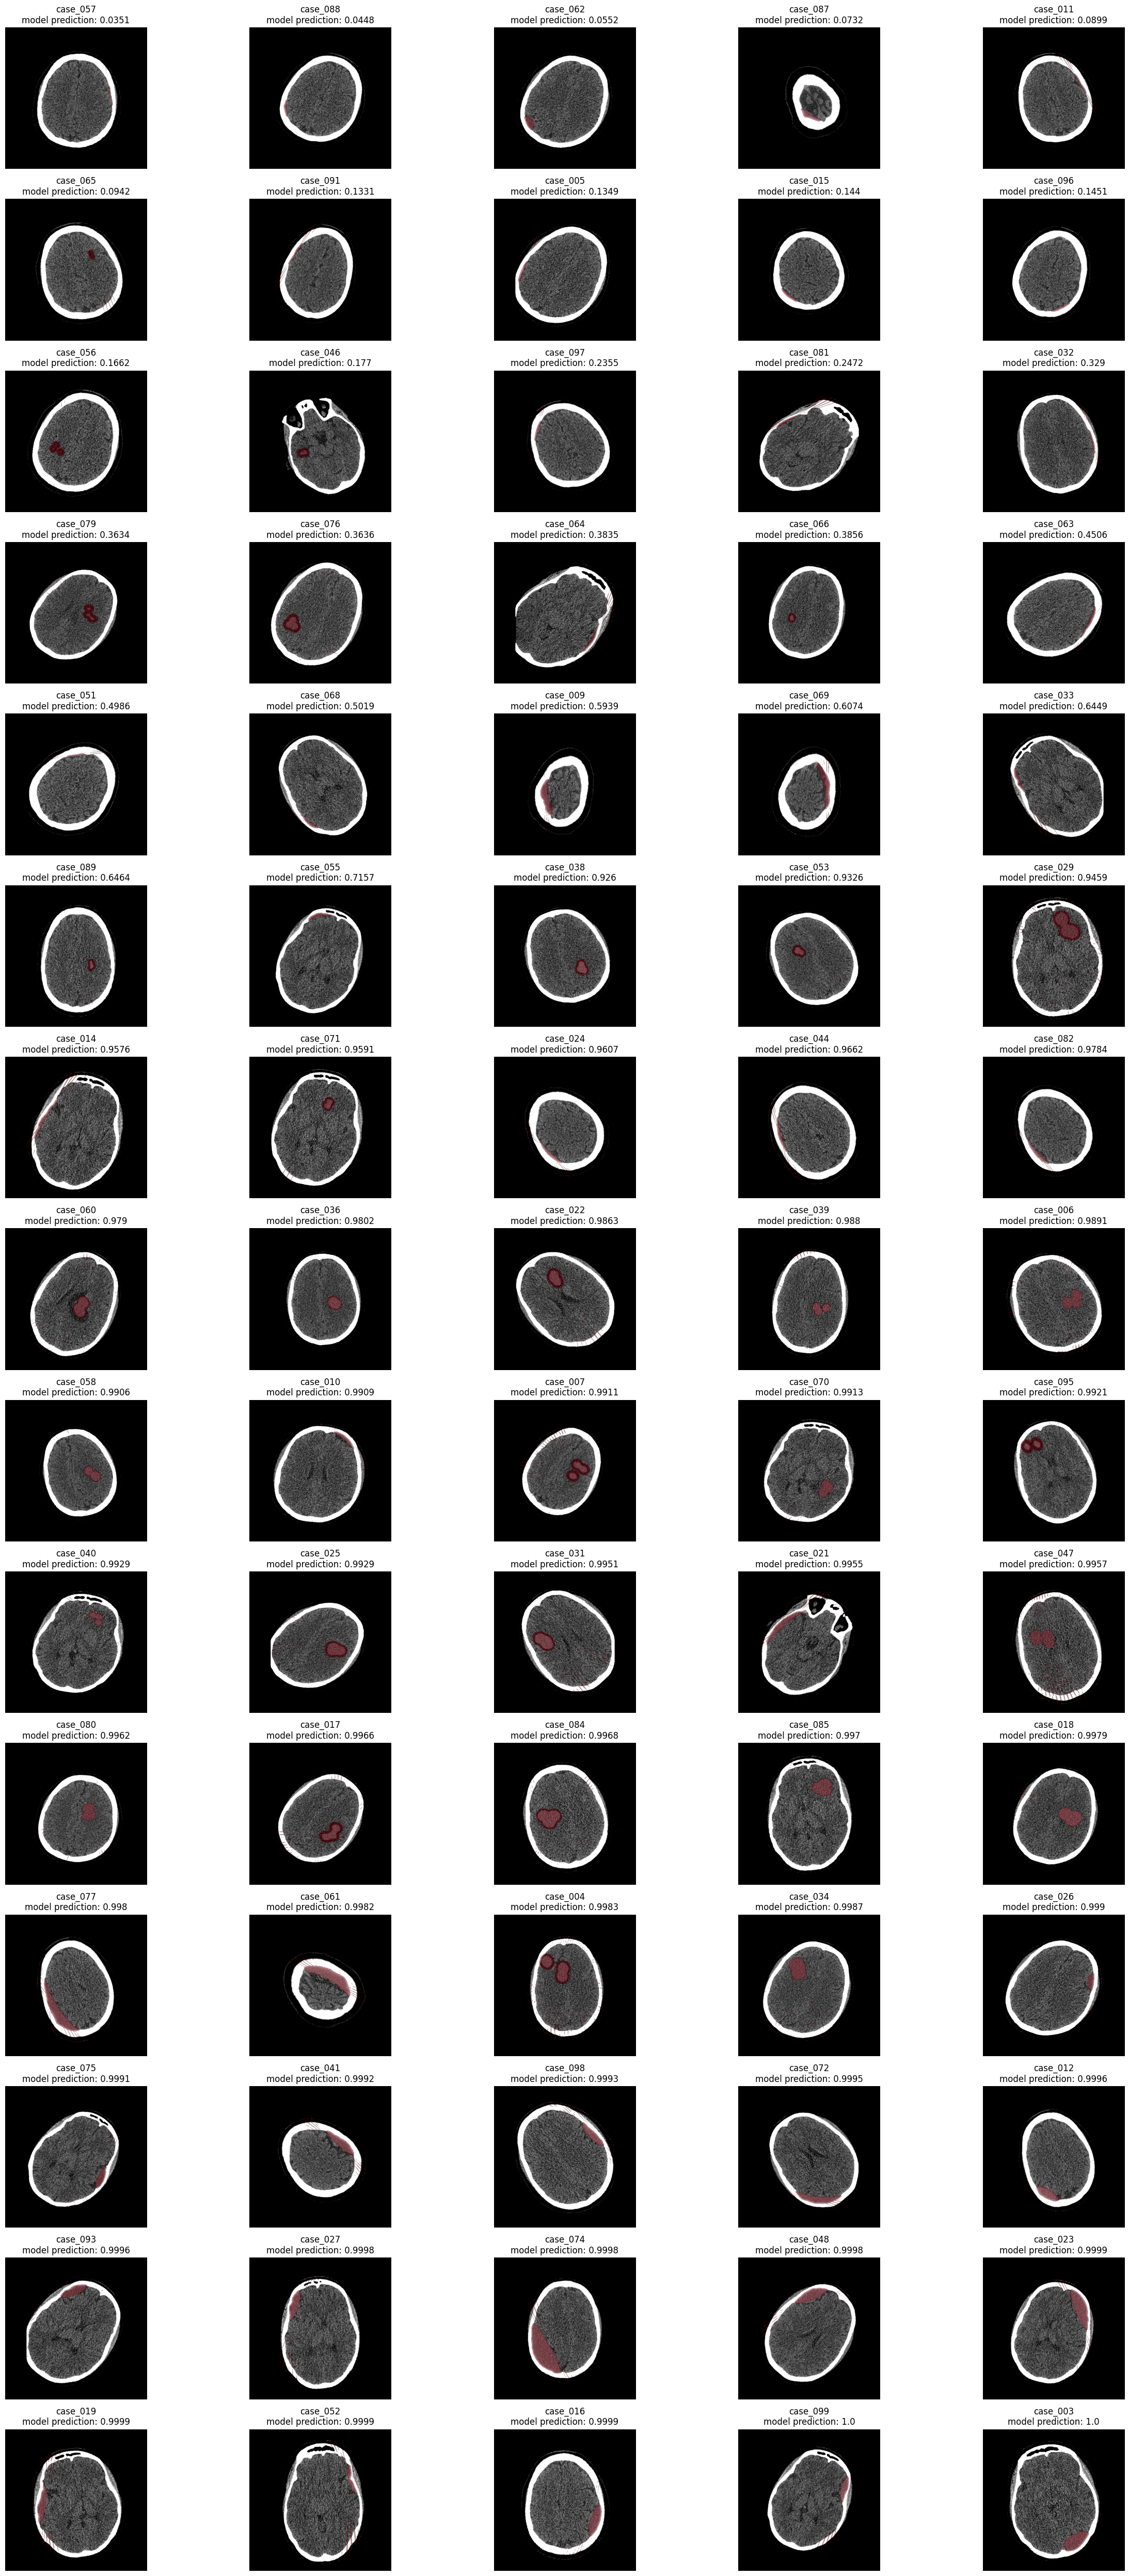

In [11]:
import sys
import pandas as pd
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import skimage as ski
import pydicom

# options
mask_method = 'boundary' # 'boundary' or 'fill'

# paths
#dataset_path = '../datasets/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.3.1'
dataset_path = '/projects01/didsr-aiml/jayse.weaver/insilicoich/mA_280_run1/'
results_df = pd.read_csv('/projects01/didsr-aiml/jayse.weaver/insilicoich/mA_280_run1/mA_280_run1_results_v2.csv')
metadata_df = pd.read_csv('/projects01/didsr-aiml/jayse.weaver/insilicoich/mA_280_run1/mA_280_run1_metadata.csv')

# sort by Model_Output, ascending=True will give lowest predictive value first
results_df = results_df.sort_values(by='pred', ascending=True)

# just visualize the cases with hemorrhage (we're looking at the false negatives)
lesion_present_IDs = results_df[results_df['truth'] == 1]['case'].tolist()

rows = 15
cols = 5
fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(25,50))
axs = axs.flat
for idx, patient in enumerate(lesion_present_IDs):
    model_pred = round(results_df[results_df['case'] == patient]['pred'].item(), 4)
    patient = str(patient).zfill(3)

    # find slice with biggest hemorrhage mask and load dicom
    case_metadata = metadata_df[metadata_df['name'] == patient]
    vol_max_idx = case_metadata['lesion volume [mL]'].idxmax()

    img_path = case_metadata['image file'][vol_max_idx]
    mask_path = case_metadata['mask file'][vol_max_idx]

    dcm = pydicom.read_file(img_path)
    img = dcm.pixel_array + int(dcm.RescaleIntercept)

    dcm = pydicom.read_file(mask_path)
    mask = dcm.pixel_array + int(dcm.RescaleIntercept)
    mask = np.where(mask > 0, 1, 0) # binarize mask

    alpha = 0.5
    cmap='Reds_r'

    # # find slice with most hemorrhage voxels
    # pixel_counts = []
    # for i in range(mask.shape[-1]):
    #     pixel_counts.append(np.sum(mask[:, :, i]))

    # if mask_method == 'boundary':
    #     mask = ski.segmentation.find_boundaries(mask[:, :, np.argmax(pixel_counts)].astype('bool'), mode='thick', background=0)
    #     alpha = 1.0
    #     cmap='spring_r'
    # else:
    #     # mask_method == 'fill'
    #     alpha = 0.5
    #     cmap='Reds_r'

    # plot
    new_mask = np.ma.masked_where(mask == False, mask)
    axs[idx].imshow(img, vmin=0, vmax=120, cmap='gray') # show img
    axs[idx].imshow(new_mask, cmap=cmap, alpha=alpha)

    axs[idx].set_title(f'{patient}\nmodel prediction: {model_pred}')
    axs[idx].axis('off')

plt.tight_layout()

